# 利用神经网络完成对手写数字进行识别

- 网络结构
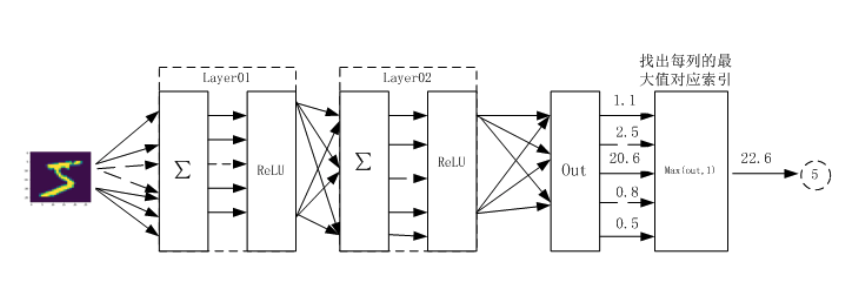
> 两个隐藏层
> 每层激活函数为Relu
> 数据集：mnist

### 1. 准备数据

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

### 2. 定义一些超参数

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

### 3. 下载数据并对数据进行预处理

In [3]:
# 定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# 判断是否需要从网络下载数据集
is_downloda = True
if os.path.exists('./data/MNIST'):
    is_downloda = False
# 下载数据，并对数据进行预处理
train_dataset = mnist.MNIST(
    './data', train=True, transform=transform, download=is_downloda)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)

# dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False)

- Normalize([0.5], [0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如三个通道，应该是Normalize([m1,m2,m3], [n1,n2,n3])
- 用DataLoader得到生成器，可节省内存。

### 4. 可视化源数据

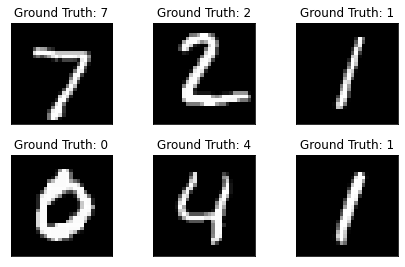

In [4]:
examples = enumerate(test_loader)
# enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标。
batch_idx, (example_data, example_targets) = next(examples)
# next() 返回迭代器的下一个项目。

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    # 关闭x,y轴显示
    plt.xticks([])
    plt.yticks([])

### 5. 构建模型

#### 5.1 构建网络

In [5]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """

    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(
            nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

#### 5.2 实例化网络

In [6]:
# 检测是否有可用的GPU，有则使用，否则使用CPU
print("GPU是否可用", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
model = Net(28 * 28, 300, 100, 10)
# 输出10维（10个数字）
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

GPU是否可用 False


### 6. 训练模型

#### 6.1 训练模型

In [7]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []


for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    # 动态修改参数学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)  # 展成1维
        # 前向传播
        out = model(img)  # 传入参数，自动执行forward函数
        loss = criterion(out, label)

        optimizer.zero_grad()  # 梯度清零
        # 反向传播
        # 缺省情况下，梯度是累加的，在梯度反向传播之前，需要梯度清零
        loss.backward()
        optimizer.step()  # 基于当前梯度，更新参数
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)  # 找出张量out最大值对应索引作为预测值
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))

    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc

    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))

    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader),
                  eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0274, Train Acc: 0.7921, Test Loss: 0.5553, Test Acc: 0.9008
epoch: 1, Train Loss: 0.4833, Train Acc: 0.8995, Test Loss: 0.3530, Test Acc: 0.9259
epoch: 2, Train Loss: 0.3504, Train Acc: 0.9187, Test Loss: 0.2769, Test Acc: 0.9384
epoch: 3, Train Loss: 0.2838, Train Acc: 0.9328, Test Loss: 0.2301, Test Acc: 0.9483
epoch: 4, Train Loss: 0.2431, Train Acc: 0.9408, Test Loss: 0.1980, Test Acc: 0.9530
epoch: 5, Train Loss: 0.2202, Train Acc: 0.9463, Test Loss: 0.1964, Test Acc: 0.9534
epoch: 6, Train Loss: 0.2188, Train Acc: 0.9464, Test Loss: 0.1913, Test Acc: 0.9537
epoch: 7, Train Loss: 0.2159, Train Acc: 0.9471, Test Loss: 0.1882, Test Acc: 0.9551
epoch: 8, Train Loss: 0.2131, Train Acc: 0.9487, Test Loss: 0.1869, Test Acc: 0.9540
epoch: 9, Train Loss: 0.2107, Train Acc: 0.9490, Test Loss: 0.1835, Test Acc: 0.9559
epoch: 10, Train Loss: 0.2081, Train Acc: 0.9500, Test Loss: 0.1846, Test Acc: 0.9552
epoch: 11, Train Loss: 0.2090, Train Acc: 0.9492, Test Loss: 0.1

#### 6.2 可视化训练及测试损失值

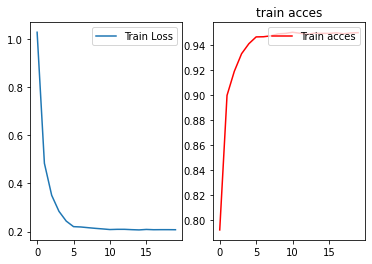

In [8]:
plt.title('train loss')
plt.subplot(1,2,1)
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

plt.subplot(1,2,2)
plt.title('train acces')
plt.plot(np.arange(len(acces)),acces,color='red', label='acces')
plt.legend(['Train acces'], loc='upper right')
